In [1]:
import requests
import time
import json
import pandas as pd
import numpy as np
from warnings import warn
import re
import pickle
import os
from datetime import date, datetime

## Исследование заработной платы по описанию вакансии
**Задача:** выявить факторы, которые больше всего влияют на размер заработной платы.
**Ограничения:**
- только вакансии со словом "аналитик"
- только Москва

На этом занятии будем исследовать данные с HH. Для этого нам пригодится [HH API](https://dev.hh.ru/).

#### Получим ID всех имеющихся вакансий

In [ ]:
params = {
    'text': 'NAME:Аналитик',  # в имени должно быть слово "Аналитик"
    'area': 1,  # поиск ощуществляется по вакансиям города Москва
    'page': 0,  # индекс страницы поиска на HH
    'per_page': 100,  # кол-во вакансий на 1 странице
    'only_with_salary': 'true'  # берем только те вакансии, где указана заработная плата
}

main_host = 'https://api.hh.ru'
entity = 'vacancies'

response = requests.get(f'{main_host}/{entity}', params)
response_content = response.content.decode()  # response.json()
response_dict = json.loads(response_content)

In [ ]:
response.status_code

In [ ]:
params = {
    'text': 'NAME:Аналитик',  # в имени должно быть слово "Аналитик"
    'area': 1,  # поиск ощуществляется по вакансиям города Москва
    'page': 0,  # индекс страницы поиска на HH
    'per_page': 100,  # кол-во вакансий на 1 странице
    'only_with_salary': 'true'  # берем только те вакансии, где указана заработная плата
}
main_host = 'https://api.hh.ru'
entity = 'vacancies'

ids = []

while True:
    response = requests.get(f'{main_host}/{entity}', params)
    
    if response.status_code == 200:
        response_content = response.content.decode()  # response.json()
        response_dict = json.loads(response_content)
    
        ids_ = [v['id'] for v in response_dict['items']]
        len_ids = len(ids_)

        ids.extend(ids_)

        if len_ids < 100:
            break
        else:
            print(f'Page {params["page"]} successfully processed!')
            params['page'] += 1
    else:
        message = f'Request finished with exit code {response.status_code}.'
        warn(message)

    time.sleep(.5)

In [ ]:
with open('ids.pickle', 'wb') as outfile:
    pickle.dump(ids, outfile)

In [ ]:
del ids

In [ ]:
with open('ids.pickle', 'rb') as infile:
    ids = pickle.load(infile)

In [ ]:
ids

In [ ]:
numbers = [1, 2, 3, 4, 5]

numbers_serialized = pickle.dumps(numbers)

In [ ]:
numbers_serialized

In [ ]:
numbers_deserialized = pickle.loads(numbers_serialized)

In [ ]:
numbers_deserialized

#### Добудем информацию о каждом резюме

In [ ]:
vacancies = []
ids_slice = ids[:400].copy()

ids_count = len(ids_slice)

for index, id_ in enumerate(ids[:400]):
    response = requests.get(f'{main_host}/{entity}/{id_}')
    
    if response.status_code == 200:
        response_content = response.content.decode()  # response.json()
        response_dict = json.loads(response_content)
        
        vacancies.append(response_dict)
        
    else:
        message = f'Request finished with exit code {response.status_code}.'
        warn(message)

        vacancies.append({})
        
    if index % 10 == 0:
        print(f'{len(vacancies)}/{ids_count} processed...')
    
    time.sleep(0.5)

In [ ]:
0.5 * 1700 / 3600

In [ ]:
response_dict

In [34]:
salary_params = ['from', 'to', 'currency', 'gross']

def process_vacancy(vacancy: dict) -> dict:
    if len(vacancy) == 0:
        return {}
    
    vacancy_processed = {}
    vacancy_processed['id'] = vacancy.get('id')

    # response_letter_required
    vacancy_processed['response_letter_required'] = vacancy.get('response_letter_required')

    # salary
    salary_exists = vacancy.get('salary') is not None
    
    for sp in salary_params:
        if salary_exists:
            vacancy_processed[f'salary_{sp}'] = vacancy['salary'].get(sp)
        else:
            vacancy_processed[f'salary_{sp}'] = None

    # lat, lng
    address = vacancy.get('address')
    
    if address is not None:
        vacancy_processed['lat'] = address.get('lat')
        vacancy_processed['lng'] = address.get('lng')
    else:
        vacancy_processed['lat'] = None
        vacancy_processed['lng'] = None

    # experience
    if 'experience' in vacancy:
        vacancy_processed['experience'] = vacancy['experience'].get('name')
    else:
        vacancy_processed['experience'] = None

    # key_skills
    if 'key_skills' in vacancy:
        vacancy_processed['key_skills'] = [skill['name'] for skill in vacancy['key_skills']]
    else:
        vacancy_processed['experience'] = []

    return vacancy_processed

In [32]:
with open('tmp/vacancies.pickle', 'rb') as infile:
    vacancies = pickle.load(infile)

In [35]:
vacancies_processed = [process_vacancy(v) for v in vacancies]

In [36]:
vacancies_processed[0]

{'id': '88603203',
 'response_letter_required': True,
 'salary_from': None,
 'salary_to': 60000,
 'salary_currency': 'RUR',
 'salary_gross': True,
 'lat': 55.746593,
 'lng': 37.537371,
 'experience': 'Нет опыта',
 'key_skills': ['SQL', 'Python']}

In [39]:
# vacancies_df = pd.DataFrame(vacancies_processed).dropna(subset=['id', 'salary_gross'])
# vacancies_df.to_excel('tmp/vacancies_df.xlsx', index=None)

#### Обработка и анализ данных

In [40]:
# vacancies_df = pd.DataFrame(vacancies_processed).dropna(subset=['id', 'salary_gross'])
vacancies_df = pd.read_excel('tmp/vacancies_df.xlsx').dropna(subset=['salary_gross'])

vacancies_df = vacancies_df[~(vacancies_df['salary_from'].isna() & vacancies_df['salary_to'].isna())].reset_index(drop=True)
vacancies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1734 entries, 0 to 1733
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        1734 non-null   int64  
 1   response_letter_required  1734 non-null   bool   
 2   salary_from               1398 non-null   float64
 3   salary_to                 1046 non-null   float64
 4   salary_currency           1734 non-null   object 
 5   salary_gross              1734 non-null   bool   
 6   lat                       953 non-null    float64
 7   lng                       953 non-null    float64
 8   experience                1734 non-null   object 
 9   key_skills                1734 non-null   object 
dtypes: bool(2), float64(4), int64(1), object(3)
memory usage: 111.9+ KB


In [3]:
vacancies_df.head()

id  response_letter_required  salary_from  salary_to  \
0  88603203.0                       1.0          NaN    60000.0   
1  81879828.0                       0.0     300000.0        NaN   
2  88629159.0                       0.0          NaN    56000.0   
3  88587403.0                       0.0          NaN    70000.0   
4  88564624.0                       0.0      80000.0        NaN   

  salary_currency  salary_gross  address_lat  address_lng  \
0             RUR           1.0    55.746593    37.537371   
1             RUR           1.0          NaN          NaN   
2             RUR           1.0          NaN          NaN   
3             RUR           1.0    55.971663    37.491602   
4             RUR           0.0    55.803479    37.390514   

                                          key_skills  
0                                  ['SQL', 'Python']  
1                                                 []  
2                                                 []  
3                                                 []  
4  ['SQL', 'Power BI', 'MS PowerPoint', 'Работа с...

In [ ]:
# ВАЖНО: просто удалить все строки с пропущенными значениями не выйдет
vacancies_df.dropna().shape

#### Разберемся с таргетом

In [ ]:
(vacancies_df['salary_from'].isna() & vacancies_df['salary_to'].isna()).sum()

In [ ]:
(vacancies_df['salary_from'].notna() & vacancies_df['salary_to'].notna()).sum()

In [ ]:
(vacancies_df['salary_from'].notna() | vacancies_df['salary_to'].notna()).sum()

In [ ]:
# Что делать с salary_from и salary_to?

#1 Усреднить
# + самая адекватная метрика ЗП
# - остается меньше половины наблюдений

#2 Заместить одно другим
# + сохраняем информацию
# + просто сделать
# - получается 2 таргета вместо 1

#3 Комбинация 1 и 2
# - получается 2 таргета вместо 1

#4 Экстраполируем пропущенные значения по уже имеющимся
# - сложнее сделать
# - "придумываем" что-то сами, НО
# + можно попробовать проконтролировать "качество" нашей задумки
# + это интересно

# РЕШЕНИЕ
# попробуем восстановить пропущенные значения несколькими способами
#1 эвристика
#2 Linear Regression - ML
#3 Random Forest     - ML
#4 Gradient Boosting - ML
# затем измерим качество и выберем наилучший вариант

**Немного про .itertuples()**

In [ ]:
from collections import namedtuple

def gross_fix(row: pd.Series) -> float:  # salary, gross
    if row['salary_gross']:
        return row.iloc[0] * 0.87
    else:
        return row.iloc[0]

def gross_fix_(row: namedtuple) -> float:  # salary, gross
    if row.salary_gross:
        return row[1] * 0.87
    else:
        return row[1]

In [ ]:
%%timeit
_ = vacancies_df[['salary_from', 'salary_gross']].apply(gross_fix, axis=1)

In [ ]:
%%timeit
_ = [gross_fix_(ntpl) for ntpl in vacancies_df[['salary_from', 'salary_gross']].itertuples()]

In [ ]:
for ntpl in vacancies_df[['salary_from', 'salary_gross']].itertuples():
    print(ntpl)

**Продолжаем**

In [4]:
vacancies_df['salary_currency'].value_counts()

salary_currency
RUR    1707
USD      25
EUR       2
Name: count, dtype: int64

In [41]:
from currency_converter import CurrencyConverter
from collections import namedtuple

converter = CurrencyConverter()
rate_date = date(2022, 2, 1)

def convert_currency(row: namedtuple) -> float:  # salary, currency
    if row.salary_currency != 'RUR':
        return converter.convert(row[1], row.salary_currency, 'RUB', rate_date)
    else:
        return row[1]

In [42]:
# DO NOT RUN MORE THAN ONCE
vacancies_df['salary_from'] = [convert_currency(row) for row in vacancies_df[['salary_from', 'salary_currency']].itertuples()]
vacancies_df['salary_to'] = [convert_currency(row) for row in vacancies_df[['salary_to', 'salary_currency']].itertuples()]

In [8]:
vacancies_df['salary_gross'].isna().sum()

0

In [43]:
vacancies_df.loc[vacancies_df['salary_gross'], 'salary_from'] = vacancies_df.loc[vacancies_df['salary_gross'], 'salary_from'] * 0.87
vacancies_df.loc[vacancies_df['salary_gross'], 'salary_to'] = vacancies_df.loc[vacancies_df['salary_gross'], 'salary_to'] * 0.87

#### Попробуем восстановить таргет
**Эвристика**

In [45]:
target_data = vacancies_df.loc[vacancies_df['salary_from'].notna() & vacancies_df['salary_to'].notna()].reset_index(drop=True)
target_data['delta'] = target_data['salary_to'] - target_data['salary_from']
target_data['delta2'] = (target_data['salary_to'] - target_data['salary_from']) / target_data['salary_from'] * 100

In [ ]:
target_data.head()

Изучаем delta между границами:

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.hist(target_data['delta'], bins=20, edgecolor='black');

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.hist(target_data.loc[target_data['delta2'] < 500, 'delta2'], bins=20, edgecolor='black');

In [ ]:
target_data['experience'].unique()

In [ ]:
target_data['experience'].value_counts()

In [ ]:
fig, ax = plt.subplots()

color_mapper = {
    'Нет опыта': 'blue',
    'От 1 года до 3 лет': 'lightblue',
    'От 3 до 6 лет': 'lightgreen',
    'Более 6 лет': 'orange',
}

for group, df in target_data.groupby(['experience']):
    experience = group[0]
    delta = df['delta']
    color = color_mapper[experience]

    ax.hist(delta, bins=20, edgecolor='black', color=color, label=experience, alpha=0.4)

ax.legend();

In [ ]:
fig, ax = plt.subplots()

color_mapper = {
    'Нет опыта': 'blue',
    'От 1 года до 3 лет': 'lightblue',
    'От 3 до 6 лет': 'lightgreen',
    'Более 6 лет': 'orange',
}

for group, df in target_data.groupby(['experience']):
    experience = group[0]
    delta = df.loc[df['delta2'] < 500, 'delta2']
    color = color_mapper[experience]

    ax.hist(delta, bins=20, edgecolor='black', color=color, label=experience, alpha=0.4)

ax.legend();

#### Ищем лучший алгоритм замены

1. Берем данные, где известны все границы;
2. Разделяем на train и test;
3. Считаем параметр(ы) на train части;
4. Проверяем на test-части.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

N_iter = 1000

In [ ]:
metrics_heur = []

for i in range(N_iter):
    # 2
    train, test = train_test_split(target_data, train_size=0.7)
    
    # 3
    parameter = (train['salary_to'] / train['salary_from']).mean()
    
    # 4
    # salary_to неизвестно
    predict = test['salary_from'] * parameter
    quality = r2_score(predict.values, test['salary_to'].values)

    metrics_heur.append({'method': 'heuristics', 'quality': quality})

metrics_df = pd.DataFrame(metrics_heur)

In [ ]:
metrics_df['quality'].hist(edgecolor='black', bins=20)

**Перейдем к моделям**

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

models = {
    'lr': LinearRegression,
    'rf': RandomForestRegressor,
    'gb': GradientBoostingRegressor
}

X = target_data[['salary_from']]
y = target_data['salary_to']

In [ ]:
metrics_models = []

for i in range(N_iter):
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)
    
    metrics_models_ = []
    
    for name, model in models.items():
        instance = model()
        instance.fit(X_train, y_train)
        predict = instance.predict(X_test)
    
        quality = r2_score(predict, y_test.values)
    
        metrics_models_.append({'method': name, 'quality': quality})

    metrics_models.extend(metrics_models_)

In [ ]:
metrics_models_df = pd.DataFrame(metrics_models)

metrics_final = pd.concat([metrics_df, metrics_models_df], ignore_index=True)

In [ ]:
metrics_final

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

color_mapper = {
    'heuristics': 'blue',
    'lr': 'green',
    'rf': 'orange',
    'gb': 'darkred',
}

for group, mini_df in metrics_final.groupby(['method']):
    method = group[0]
    color = color_mapper[method]

    ax.hist(mini_df['quality'], bins=20, edgecolor='black', color=color, label=method, alpha=0.2)

ax.legend();

In [ ]:
metrics_final.groupby(['method'], as_index=False).mean().sort_values(by='quality', ascending=False)

In [ ]:
metrics_final.groupby(['method'], as_index=False).median().sort_values(by='quality', ascending=False)

In [ ]:
# РЕШЕНИЕ: восстанавливаем таргет с помощью простой эвристики
# считаем, что 0.74 - хорошее качество

#### Восстановим таргет

In [47]:
vacancies_df_model

response_letter_required    salary_from      salary_to        lat  \
0                            1   34772.152528   52200.000000  55.746593   
1                            0  261000.000000  391813.534950        NaN   
2                            0   32454.009027   48720.000000        NaN   
3                            0   40567.511283   60900.000000  55.971663   
4                            0   80000.000000  120096.102667  55.803479   
...                        ...            ...            ...        ...   
1729                         0   80000.000000  180000.000000  55.734075   
1730                         1   80000.000000  120096.102667  55.778593   
1731                         0  230000.000000  250000.000000        NaN   
1732                         0  180000.000000  250000.000000        NaN   
1733                         0   50000.000000   75060.064167        NaN   

            lng          experience  \
0     37.537371           Нет опыта   
1           NaN       От 3 до 6 лет   
2           NaN           Нет опыта   
3     37.491602           Нет опыта   
4     37.390514  От 1 года до 3 лет   
...         ...                 ...   
1729  37.663584  От 1 года до 3 лет   
1730  37.682269  От 1 года до 3 лет   
1731        NaN       От 3 до 6 лет   
1732        NaN  От 1 года до 3 лет   
1733        NaN  От 1 года до 3 лет   

                                             key_skills         target  
0                                     ['SQL', 'Python']   43486.076264  
1                                                    []  326406.767475  
2                                                    []   40587.004513  
3                                                    []   50733.755642  
4     ['SQL', 'Power BI', 'MS PowerPoint', 'Работа с...  100048.051333  
...                                                 ...            ...  
1729  ['Постановка задач разработчикам', 'Управление...  130000.000000  
1730  ['Работа с большим объемом информации', 'Анали...  100048.051333  
1731  ['BPMN', 'UML', 'Agile Project Management', 'С...  240000.000000  
1732  ['Atlassian Jira', 'Проведение тестирований', ...  215000.000000  
1733  ['Работа с большим объемом информации', 'MS Vi...   62530.032083  

[1734 rows x 8 columns]

In [77]:
def from_str_to_list(string: str) -> list:
    string_list = [skill.strip("'") for skill in string.strip('[]').split(', ') if skill != '']

    if len(string_list) == 0:
        return []
    else:
        return string_list

ratio = (target_data['salary_to'] / target_data['salary_from']).mean()

vacancies_df_model = vacancies_df.drop(columns=['id', 'salary_currency', 'salary_gross']).rename(
    columns={'lat': 'address_lat', 'lng': 'address_lng'}
)


# salary_to
vacancies_df_model.loc[
    vacancies_df_model['salary_to'].isna(), 'salary_to' 
] = vacancies_df_model.loc[
    vacancies_df_model['salary_to'].isna(), 'salary_from' 
] * ratio

# salary_from
vacancies_df_model.loc[
    vacancies_df_model['salary_from'].isna(), 'salary_from'
] = vacancies_df_model.loc[
    vacancies_df_model['salary_from'].isna(), 'salary_to' 
] / ratio

# create target
vacancies_df_model['target'] = vacancies_df_model[['salary_from', 'salary_to']].values.mean(axis=1)

# fix features
vacancies_df_model['response_letter_required'] = vacancies_df_model['response_letter_required'].astype(int)
vacancies_df_model['address_exists'] = vacancies_df_model['address_lat'].notna().astype(int)
vacancies_df_model['key_skills'] = vacancies_df_model['key_skills'].map(from_str_to_list)
vacancies_df_model['skills_number'] = vacancies_df_model['key_skills'].map(lambda skills: len(skills))

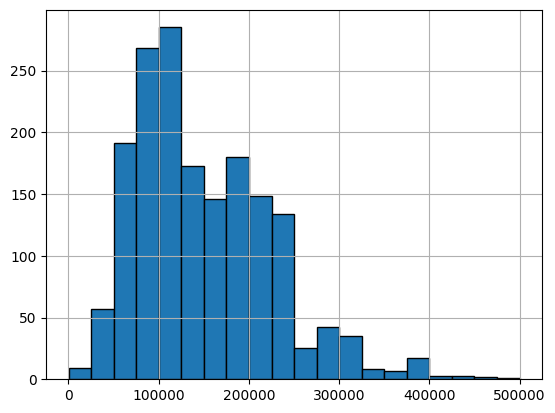

In [12]:
vacancies_df_model['target'].hist(bins=20, edgecolor='black');

#### Займемся моделью
Фичи:

- response_letter_required - возьмем, но выкинем, если она окажется неважной
- address_lat & address_lng -> address_exists - берем
- experience - берем
- key_skills

In [50]:
vacancies_df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1734 entries, 0 to 1733
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   response_letter_required  1734 non-null   int64  
 1   salary_from               1734 non-null   float64
 2   salary_to                 1734 non-null   float64
 3   address_lat               953 non-null    float64
 4   address_lng               953 non-null    float64
 5   experience                1734 non-null   object 
 6   key_skills                1734 non-null   object 
 7   target                    1734 non-null   float64
 8   address_exists            1734 non-null   int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 122.1+ KB


In [18]:
# response_letter_required
vacancies_df_model['response_letter_required'].value_counts()

response_letter_required
0    1696
1      38
Name: count, dtype: int64

<Axes: >

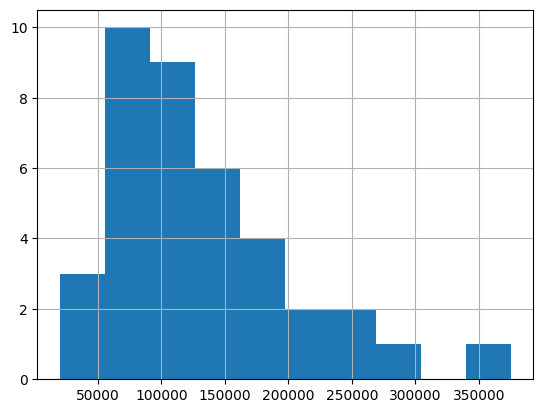

In [21]:
vacancies_df_model.loc[vacancies_df_model['response_letter_required'] == 1, 'target'].hist()

In [23]:
vacancies_df_model.groupby(['response_letter_required'])['target'].median()

response_letter_required
0    140000.0
1    120000.0
Name: target, dtype: float64

In [ ]:
# ВЫЧИСЛИТЕЛЬНЫЙ ЭКСПЕРИМЕНТ

#1 H0: разница в группах по случайным причинам
#2 Насколько вероятно получить наблюдаемое значение разницы (или более экстремальное) при условии, что H0 верна? -> p-value
#3 Какое бы распределение имели значения разности при условии H0?
#4 Какое место в этом распределении занимает наблюдаемое значение разности? Насколько экстремально?

# СТАТТЕСТ
#1 H0: разница в группах по случайным причинам

#2 выбор корректного статтеста

#4 Какое место в этом распределении занимает наблюдаемое значение разности? Насколько экстремально?

In [24]:
from scipy import stats

In [49]:
stats.mannwhitneyu(
    vacancies_df_model.loc[vacancies_df_model['response_letter_required'] == 1, 'target'].values,
    vacancies_df_model.loc[vacancies_df_model['response_letter_required'] == 0, 'target'].values
)

MannwhitneyuResult(statistic=26082.0, pvalue=0.04420971923461414)

In [28]:
vacancies_df_model.groupby(['address_exists'])['target'].median()

address_exists
0    150072.077000
1    125060.064167
Name: target, dtype: float64

In [27]:
# address_exists
stats.mannwhitneyu(
    vacancies_df_model.loc[vacancies_df_model['address_exists'] == 1, 'target'].values,
    vacancies_df_model.loc[vacancies_df_model['address_exists'] == 0, 'target'].values
)

MannwhitneyuResult(statistic=328681.0, pvalue=2.779378323422509e-05)

#### Исследуем key_skills

1. Установим нижнюю границу встречаемости навыка - 50;
2. Рассмотрим каждую 

In [58]:
lower_count_bound = 50

key_skills = pd.Series([skill for skills in vacancies_df_model['key_skills'].dropna().tolist() for skill in skills])
skills_count = key_skills.value_counts()

skills_to_check = skills_count.index[skills_count.values >= 50]

In [57]:
def check_skill(skill: str, data: pd.DataFrame) -> dict:
    indicator = data['key_skills'].map(lambda skills: skill in skills) 
    
    skill_yes = data.loc[indicator, 'target']
    skill_no = data.loc[~indicator, 'target']

    # get stats
    mannwhitneyu_pval = stats.mannwhitneyu(skill_yes.values, skill_no.values).pvalue
    median_diff = skill_yes.median() - skill_no.median()

    return {'skill': skill, 'difference': median_diff, 'p_value': mannwhitneyu_pval}

In [66]:
len(skills_to_check)

35

In [67]:
p_mistake = 0.05

# какая вероятность ошибиться 5 раз за все 35 проверок?

In [70]:
n = len(skills_to_check)
p = p_mistake

binom = stats.binom(n, p)

In [72]:
binom.pmf(4)

0.06672850872530994

In [73]:
binom.pmf(0)

0.1660833839876074

In [75]:
skill_checks = [check_skill(skill, vacancies_df_model[['key_skills', 'target']]) for skill in skills_to_check]
skills_df = pd.DataFrame(skill_checks)

skills_df['p_value_adjusted'] = skills_df['p_value'] * n

In [76]:
p_value_cutoff = 0.05

skills_df[skills_df['p_value'] <= p_value_cutoff].sort_values(by=['difference'], ascending=False).iloc[:10]

skill    difference       p_value  \
28                            REST  90595.992217  6.268427e-15   
10                             UML  84939.935833  3.378785e-17   
22                  Atlassian Jira  83801.054542  2.192842e-10   
7                 Системный анализ  83206.584608  6.943373e-17   
5                             BPMN  77874.958400  3.914574e-16   
18          ERP-системы на базе 1С  60755.707146  9.513088e-09   
11  Постановка задач разработчикам  57173.253511  4.739870e-11   
1                              SQL  56131.920268  8.164998e-17   
9   Разработка технических заданий  49877.405801  1.737734e-08   
4                    Бизнес-анализ  41553.254853  3.275517e-08   

    p_value_adjusted  
28      2.193949e-13  
10      1.182575e-15  
22      7.674947e-09  
7       2.430181e-15  
5       1.370101e-14  
18      3.329581e-07  
11      1.658955e-09  
1       2.857749e-15  
9       6.082069e-07  
4       1.146431e-06

In [65]:
skills_df[skills_df['p_value'] <= p_value_cutoff].sort_values(by=['difference'], ascending=True).iloc[:10]

skill    difference       p_value
8                              MS Excel -42533.035292  3.611063e-14
3   Работа с большим объемом информации -37483.035292  3.954855e-09
12                        MS PowerPoint -37410.000000  4.781721e-10
20                         Анализ рынка -35689.077385  3.357258e-07
34                                Excel -30514.655657  1.820383e-06
32               Подготовка презентаций -30514.655657  2.273368e-04
0                Аналитическое мышление -28722.500000  1.057522e-08
13             Сбор и анализ информации -26563.187503  7.315829e-05
15               Работа с базами данных -25562.706990  2.450980e-03
31                 Маркетинговый анализ -20562.706990  3.316847e-03

In [80]:
# skills_number
vacancies_df_model['skills_number'].value_counts().plot.bar();

In [81]:
vacancies_df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1734 entries, 0 to 1733
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   response_letter_required  1734 non-null   int64  
 1   salary_from               1734 non-null   float64
 2   salary_to                 1734 non-null   float64
 3   address_lat               953 non-null    float64
 4   address_lng               953 non-null    float64
 5   experience                1734 non-null   object 
 6   key_skills                1734 non-null   object 
 7   target                    1734 non-null   float64
 8   address_exists            1734 non-null   int64  
 9   skills_number             1734 non-null   int64  
dtypes: float64(5), int64(3), object(2)
memory usage: 135.6+ KB


#### Перейдем к модели

In [82]:
from transliterate import translit

variables = ['target', 'response_letter_required', 'address_exists', 'experience', 'key_skills', 'skills_number']
model_df = vacancies_df_model[variables].copy()

# experience
model_df['experience'] = model_df['experience'].map(lambda ex: translit(ex, 'en', 'ru', reversed=True))

In [84]:
from transliterate import translit



In [83]:
model_df['experience']

0                Нет опыта
1            От 3 до 6 лет
2                Нет опыта
3                Нет опыта
4       От 1 года до 3 лет
               ...        
1729    От 1 года до 3 лет
1730    От 1 года до 3 лет
1731         От 3 до 6 лет
1732    От 1 года до 3 лет
1733    От 1 года до 3 лет
Name: experience, Length: 1734, dtype: object